In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import cellrank as cr

from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'reprogramming_model.cpt',
                               '--exp-name', 'CohAE_reprogramming',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '5',
                            #    '--nb_g_src', 'X',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', None,
                               '--fit_offset_pred', 'True',
                               '--use_offset_pred', None,
                               '--use_gcn', None
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:
cluster_edges = []
k_cluster = "reprogramming_day"
# k_cluster = "celltype" 
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = cr.datasets.reprogramming_morris()
sel = np.array(list(map(lambda x: type(x) == type(""), adata.obs.reprogramming_day)))
sel = sel & np.array(np.isnan(adata.obsm['X_tsne']).sum(axis=1) == 0)
adata = adata[sel]
adata.obsm['X_umap'] = adata.obsm['X_tsne']
adata.obs[k_cluster] = adata.obs[k_cluster].astype(str)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.71 0.29]
Filtered out 12168 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:29) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:14) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 48515 × 2000
    obs: 'timecourse', 'reprogramming_day', 'reprogramming', 'cell_type', 'cell_cycle', 'cluster', 'monocle_state', 'pseudotime', 'CellTagD0_85k', 'CellTagD3_85k', 'CellTagD13_85k', 'CellTagD0_48k', 'CellTagD3_48k', 'CellTagD13_48k', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    u

computing velocities
    finished (0:01:03) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/40 cores)
or disable the progress bar using `show_progress_bar=False`.


/data/users/cqiao/.conda_envs/veloAE/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:03:15) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:26) --> added
    'stc_velocity_tsne', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_reprogramming_stc.png


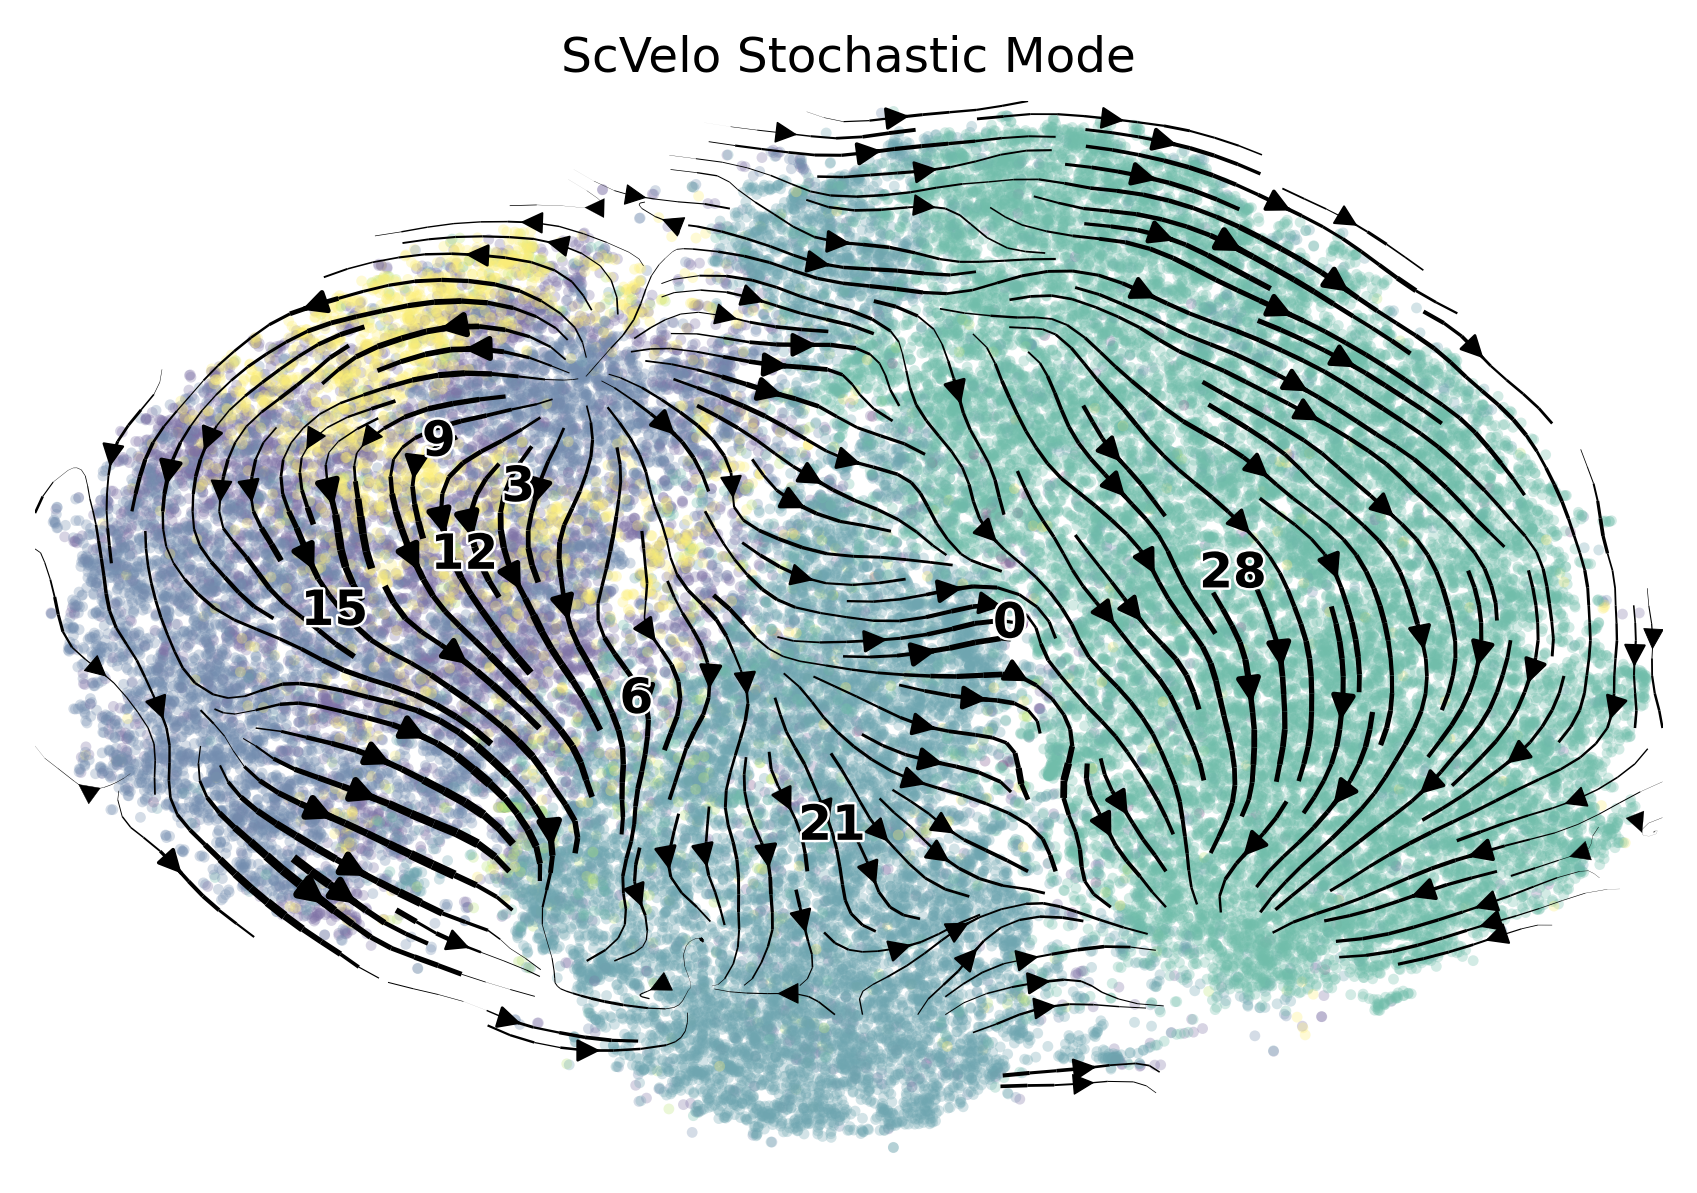

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'0': 0.8607853, '12': 0.8612092, '15': 0.8675324, '21': 0.81986326, '28': 0.73049444, '3': 0.8863556, '6': 0.83323896, '9': 0.87461025}
Total Mean: 0.8417611718177795
# In-cluster Confidence
{'0': 0.7577561489741007, '12': 0.8148321941619618, '15': 0.8178984837707513, '21': 0.797419463407724, '28': 0.7503800696624948, '3': 0.727196146141399, '6': 0.7637222583001515, '9': 0.8224755562378713}
Total Mean: 0.7814600400820568


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=10)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
adata.obs[k_cluster] = adata.obs[k_cluster].astype(str)
scv.pl.velocity_embedding_stream(adata,  
                                # legend_loc="right margin", 
                                vkey="stc_velocity", 
                                basis='X_tsne', 
                                color=[k_cluster],
                                dpi=350, 
                                save="reprogramming_stc.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:13) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 18.590652
Train Epoch: 200/20000 	Loss: 18.418175
Train Epoch: 300/20000 	Loss: 18.237631
Train Epoch: 400/20000 	Loss: 18.056208
Train Epoch: 500/20000 	Loss: 17.871613
Train Epoch: 600/20000 	Loss: 17.687708
Train Epoch: 700/20000 	Loss: 17.499229
Train Epoch: 800/20000 	Loss: 17.301397
Train Epoch: 900/20000 	Loss: 17.095394
Train Epoch: 1000/20000 	Loss: 16.883394
Train Epoch: 1100/20000 	Loss: 16.665024


computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:23) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 10/40 cores)


  0%|          | 0/48515 [00:00<?, ?cells/s]

/data/users/cqiao/conda_envs/lib/python3.7/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:03:18) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:35) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_reprogramming_pojection.png


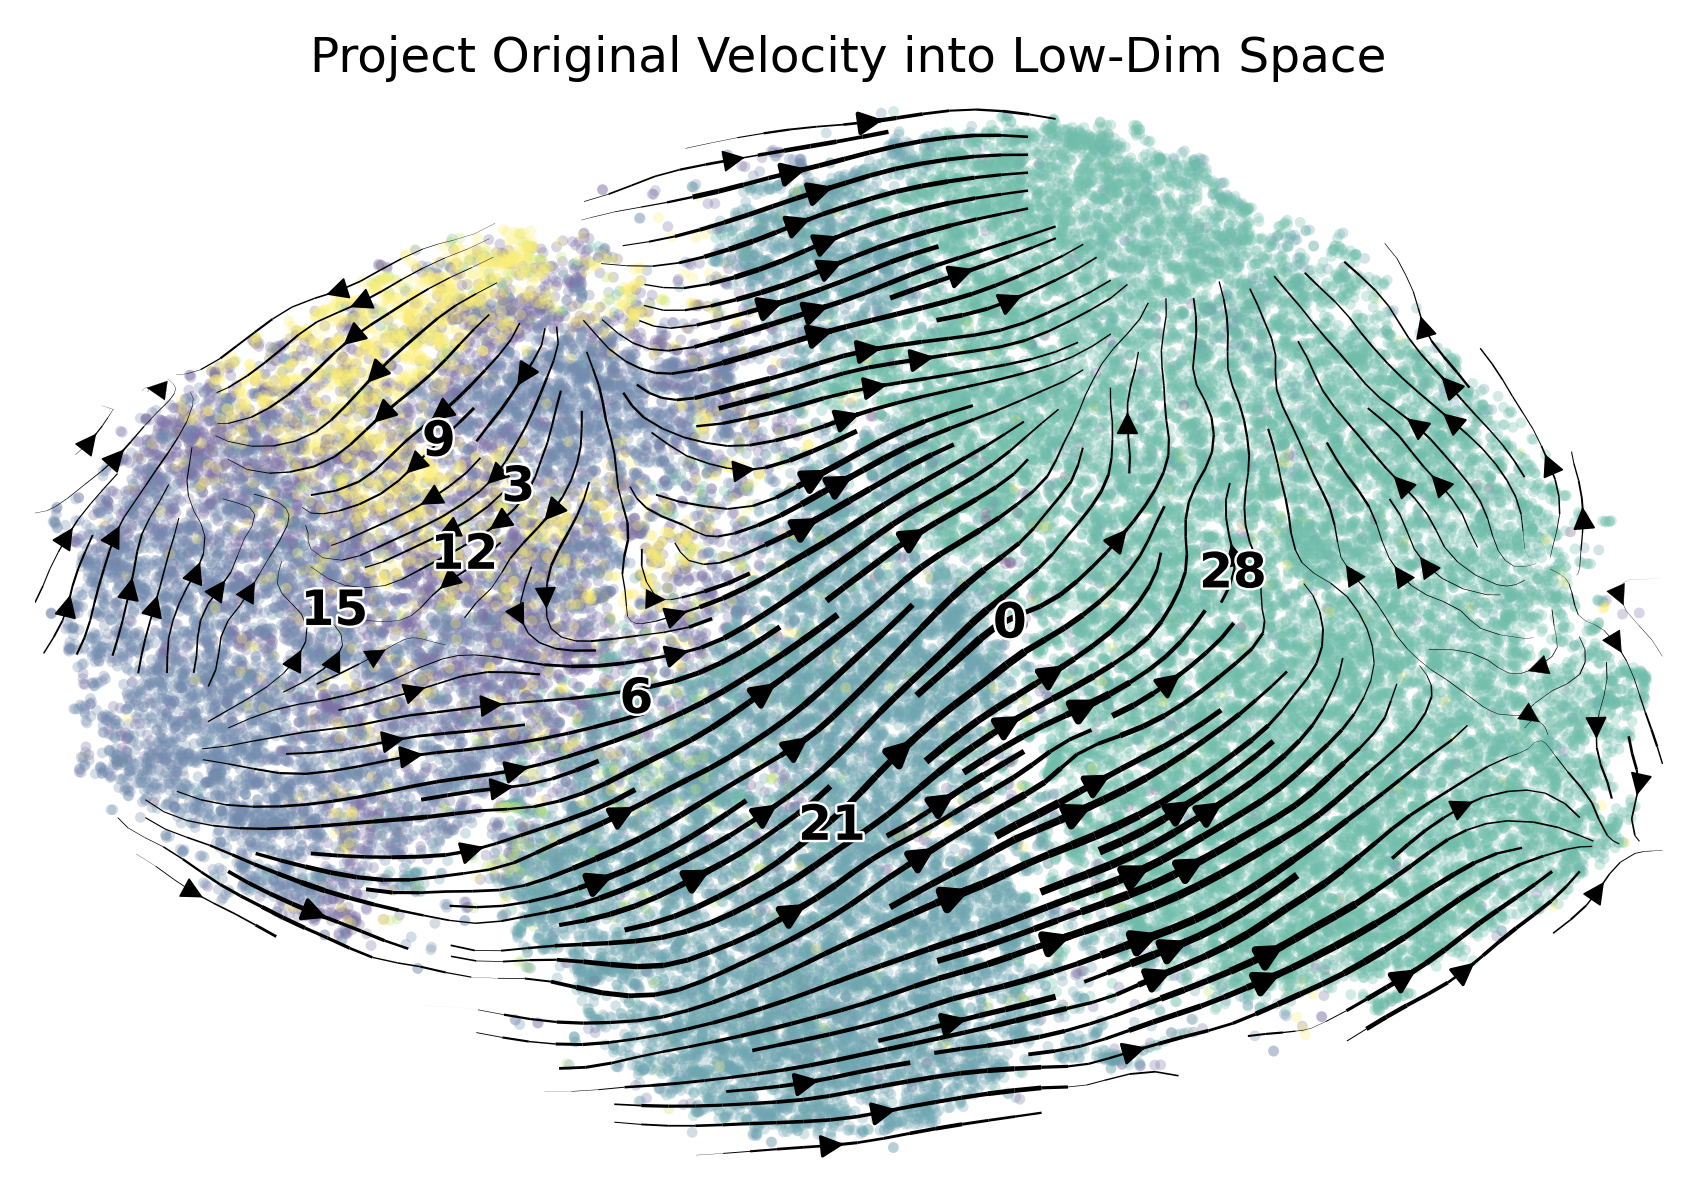

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'0': 0.9996944, '12': 0.9995699, '15': 0.99956214, '21': 0.99964505, '28': 0.99964285, '3': 0.9998836, '6': 0.9997765, '9': 0.9995787}
Total Mean: 0.9996691942214966
# In-cluster Confidence
{'0': 0.9992448647816976, '12': 0.9994911697300958, '15': 0.9994821784852931, '21': 0.9995738950376996, '28': 0.9996019307885184, '3': 0.9993001222610474, '6': 0.9994875657108595, '9': 0.9994766115877599}
Total Mean: 0.9994572922978714


In [ ]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=True).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=10)
    scv.pl.velocity_embedding_stream(adata,  # legend_loc='right_margin', 
                                    vkey="new_velocity", basis='X_umap', color=[k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save='reprogramming_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
exp(adata, exp_metrics)

In [ ]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=True).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis='X', n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=10)
    scv.pl.velocity_embedding_stream(adata,  # legend_loc='right_margin', 
                                    vkey="new_velocity", basis='X_umap', color=[k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save='reprogramming_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
exp(adata, exp_metrics)

In [ ]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)